In [1]:
#
# This section taken from MaterialsAutomated0-CurieWeiss
#
import logging
import csv

# Section aware importer of a PPMS data file
def readPPMSDataFile(file):
    rv = {}
    with open(file, newline="") as f:
        r = csv.reader(f,delimiter=',')
        hdr = []
        data = []
        section = None
        for l in r:
            if len(l) > 0:
                if l[0].lower() == '[Header]'.lower():
                    section = hdr
                elif l[0].lower() == '[Data]'.lower():
                    section = data
                elif len(l[0]) > 0 and l[0][0] == ';':
                    pass # ignore commented out lines
                elif section != None:
                    section.append(l)
                else:
                    logging.warning("No section yet defined for line: %s", l)
            else:
                logging.info("Ignoring empty line: %s", l)
        rv['header'] = hdr
        rv['data'] = data
    return rv

# Get the names of all the header variables
def getHeaders(fileData):
    rv = None
    if 'header' in fileData:
        rv = []
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            rv.append(l[0])
    return rv
   
# Get the value of a named header variable
def getHeaderValue(fileData, name):
    rv = None
    if 'header' in fileData:
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            if l[0].lower() == name.lower():
                if len(l) > 1:
                    val = ''.join(l[1:])
                else:
                    val = ''
                if rv is None:
                    rv = []
                rv.append(val)
    if (len(rv) > 1):
        return rv
    return rv[0]

# Get the names of the available data columns
def getDataColumns(fileData):
    rv = None
    if 'data' in fileData and len(fileData['data']) > 0:
        rv = fileData['data'][0]
    return rv

# Get the entries stored in one data column
def getDataColumn(fileData, name, prefixMatching=True):
    rv = None
    if 'data' in fileData:
        headers = None
        nameIndex = None
        headerName = None
        for l in fileData['data']:
            if headers is None:
                headers = l
                for i,h in enumerate(headers):
                    if ((prefixMatching and len(h) >= len(name) and h[0:len(name)].lower() == name.lower()) or
                       (not prefixMatching and h.lower() == name.lower())):
                        if nameIndex is None:
                            nameIndex = i
                            headerName = h
                            rv = []
                        else:
                            logging.warning("Ambiguous column selected: %s and %s both match %s", headerName, h, name)
            elif nameIndex != None:
                if len(l) > nameIndex:
                    try:
                        rv.append(float(l[nameIndex]))
                    except ValueError:
                        rv.append(l[nameIndex])
                else:
                    rv.append(None)
                    logging.warning("Unusually short line in data section: %s", l)
    return rv

In [2]:
import numpy as np
def cleanupRT(temp,R,minR=0.0,maxR=1000000.0,filterT=True):
    rv = []
    minT = 0.0
    for i in range(0,len(temp)):
        try:
            if (float(R[i]) > maxR) and float(temp[i]) > minT:
                minT = temp[i]
            if (float(R[i]) >= minR and float(R[i]) < maxR):
                rv.append([float(temp[i]),float(R[i])])
        except ValueError:
            pass
    rv = np.array(rv)
    if filterT:
        rv = rv[rv[:,0] > minT,:]
    return rv

In [3]:
curFile = readPPMSDataFile("20110928_AFe2X3.dat")
# Could improve by breaking up the R(T) into sub-experiments
temp = getDataColumn(curFile,"Temperature")
R1 = getDataColumn(curFile,"Bridge 1 Resistance")
R2 = getDataColumn(curFile,"Bridge 2 Resistance")
R3 = getDataColumn(curFile,"Bridge 3 Resistance")
TR1 = cleanupRT(temp,R1)
TR2 = cleanupRT(temp,R2)
TR3 = cleanupRT(temp,R3)
TRs = [[0.005,TR1],[0.0075,TR2],[0.015,TR3]]

<IPython.core.display.Javascript object>


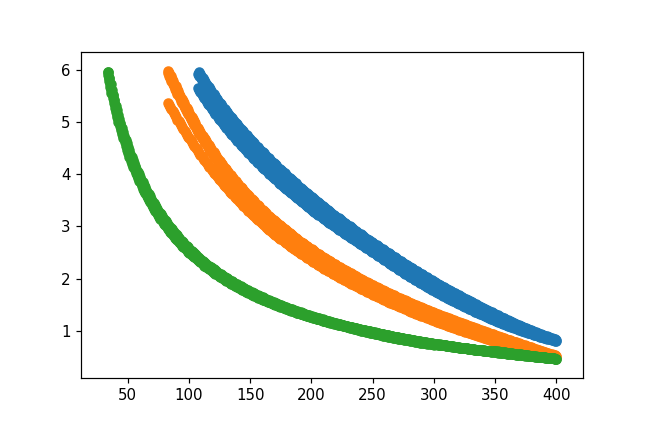

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(TR1[:,0],np.log10(TR1[:,1]))
plt.scatter(TR2[:,0],np.log10(TR2[:,1]))
plt.scatter(TR3[:,0],np.log10(TR3[:,1]))

In [5]:
import numpy as np
import scipy.constants
def fitRT(temp,R,invTmin=0.0,Tpower=1.0):
    invT = 1/temp**Tpower
    lgR = np.log(R)
    fit = np.polyfit(invT[invT>invTmin],lgR[invT>invTmin],1)
    gap = 2.0*scipy.constants.Boltzmann*fit[0]/scipy.constants.elementary_charge
    return [gap,invT,lgR,fit]

<IPython.core.display.Javascript object>


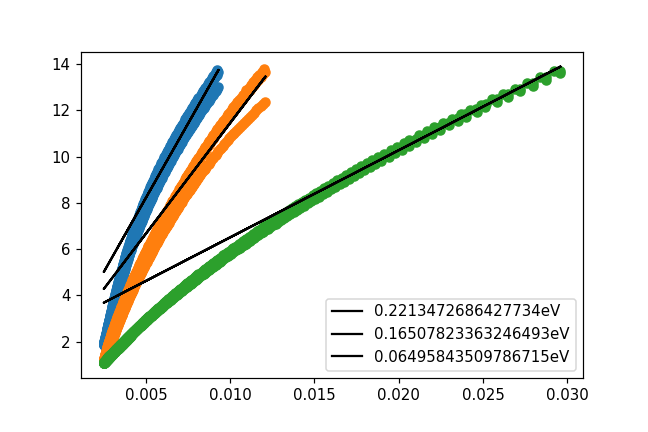

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
for TRarr in TRs:
    TR = TRarr[1]
    fR = fitRT(TR[:,0],TR[:,1],invTmin=TRarr[0])
    plt.plot(fR[1],fR[2],'o')
    plt.plot(fR[1],np.polyval(fR[3],fR[1]),'k',label=str(fR[0])+"eV")
plt.legend()

In [ ]:
#import scipy.constants
#gap = 2.0*scipy.constants.Boltzmann*fit[0]/scipy.constants.elementary_charge # units of eV
#print("Gap: ", gap, "eV")

<IPython.core.display.Javascript object>


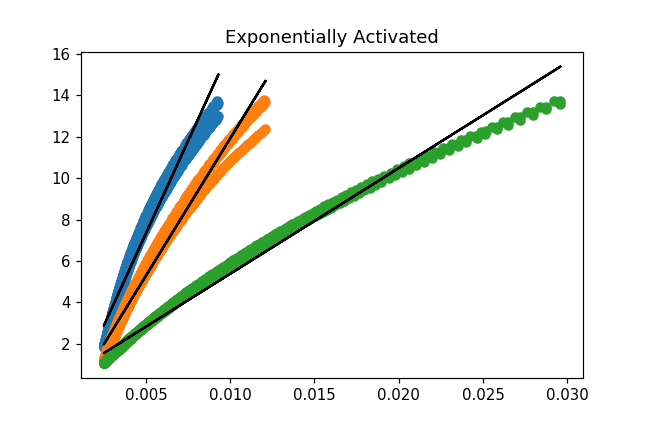

<IPython.core.display.Javascript object>


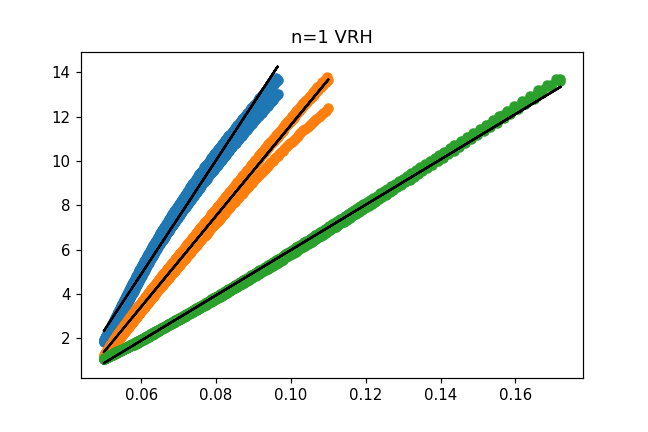

<IPython.core.display.Javascript object>


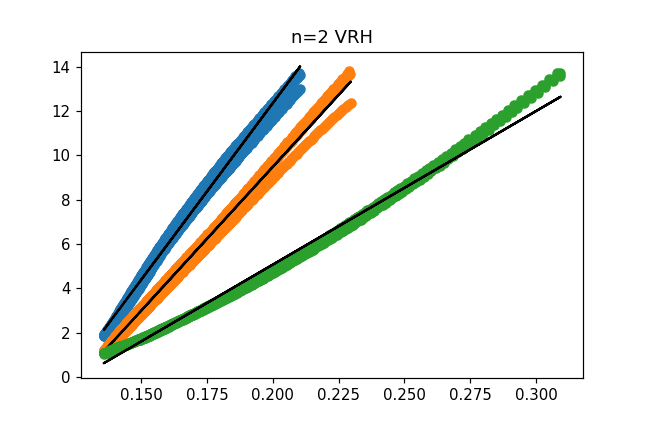

<IPython.core.display.Javascript object>


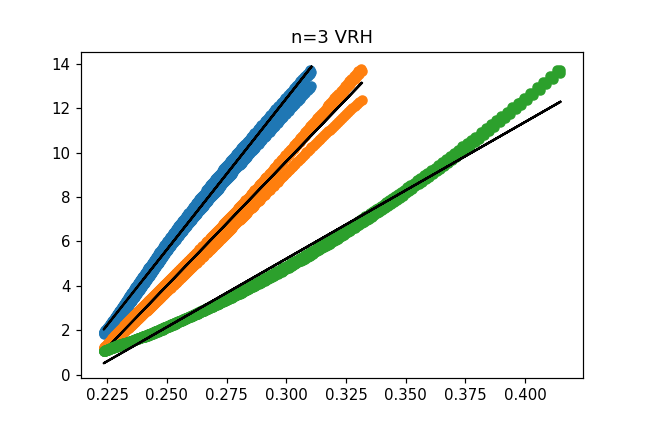

In [7]:

%matplotlib notebook
import matplotlib.pyplot as plt
# 1/T
plt.figure()
plt.title("Exponentially Activated")
for TRarr in TRs:
    TR = TRarr[1]
    fR = fitRT(TR[:,0],TR[:,1],Tpower=1.0)
    plt.plot(fR[1],fR[2],'o')
    plt.plot(fR[1],np.polyval(fR[3],fR[1]),'k')
# 1/T^(1/(n+1)) n = dimensionality (1,2,3)
# n = 1
plt.figure()
plt.title("n=1 VRH")
for TRarr in TRs:
    TR = TRarr[1]
    fR = fitRT(TR[:,0],TR[:,1],Tpower=1/(1+1))
    plt.plot(fR[1],fR[2],'o')
    plt.plot(fR[1],np.polyval(fR[3],fR[1]),'k')
# 1/T^(1/(n+1)) n = dimensionality (1,2,3)
# n = 2
plt.figure()
plt.title("n=2 VRH")
for TRarr in TRs:
    TR = TRarr[1]
    fR = fitRT(TR[:,0],TR[:,1],Tpower=1/(2+1))
    plt.plot(fR[1],fR[2],'o')
    plt.plot(fR[1],np.polyval(fR[3],fR[1]),'k')
# 1/T^(1/(n+1)) n = dimensionality (1,2,3)
# n = 3
plt.figure()
plt.title("n=3 VRH")
for TRarr in TRs:
    TR = TRarr[1]
    fR = fitRT(TR[:,0],TR[:,1],Tpower=1/(3+1))
    plt.plot(fR[1],fR[2],'o')
    plt.plot(fR[1],np.polyval(fR[3],fR[1]),'k')